In [1]:
import numpy as np
import pandas as pd
from math import * 
import pickle
from pathlib import Path
from matplotlib import pyplot as plt
import warnings
from scipy.signal import butter, lfilter
warnings.simplefilter('ignore')

In [2]:
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)
        
def from_pickle(filename):
    with open(filename, mode='rb') as f:
        obj = pickle.load(f)
    return obj

In [3]:
def load_data(input_dir):
    acc_df = from_pickle(input_dir/'imu_dataset_v0/train/acc.pkl')    
    mag_df = from_pickle(input_dir/'imu_dataset_v0/train/mag.pkl')
    gt_df = pd.read_csv(input_dir/'all_ground_truth.csv')
    acc_df['phone'] = acc_df['collectionName'] + "_" + acc_df['phoneName']
    mag_df['phone'] = mag_df['collectionName'] + "_" + mag_df['phoneName']
    gt_df['phone'] = gt_df['collectionName'] + "_" + gt_df['phoneName']
    return acc_df, mag_df, gt_df

In [4]:
# lowpass filter
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff=2.5, fs=50.0, order=3):
    b, a = butter_lowpass(cutoff, fs, order)
    y = lfilter(b, a, data)
    return y

In [16]:
# Offset correction
# refarence https://github.com/J-ROCKET-BOY/SS-Fitting

def SS_fit(data) : 

    x = data[:,[0]]
    y = data[:,[1]]
    z = data[:,[2]]

    data_len = len(x)
    
    x2 = np.power(x,2)
    y2 = np.power(y,2)
    z2 = np.power(z,2)

    r1 = -x*(x2+y2+z2)
    r2= -y*(x2+y2+z2)
    r3 = -z*(x2+y2+z2)
    r4 = -(x2+y2+z2)

    left = np.array([[np.sum(x2),np.sum(x*y),np.sum(x*z),np.sum(x)],
                     [np.sum(x*y),np.sum(y2),np.sum(y*z),np.sum(y)],
                     [np.sum(x*z),np.sum(y*z),np.sum(z2),np.sum(z)],
                     [np.sum(x), np.sum(y), np.sum(z), data_len]])
    
    right = np.array([np.sum(r1),
                      np.sum(r2),
                      np.sum(r3),
                      np.sum(r4)])
    
    # si = np.dot(np.linalg.inv(left),right)
    si = np.dot(np.linalg.pinv(left),right)

    x0 = (-1/2)* si[0]
    y0 = (-1/2)* si[1]
    z0 = (-1/2)* si[2]
    
    return np.array([x0,y0,z0])

In [6]:
# Vincenty's formulae
# refarence https://qiita.com/r-fuji/items/99ca549b963cedc106ab

def vincenty_inverse(lat1, lon1, lat2, lon2):

    # Not advanced
    if isclose(lat1, lat2) and isclose(lon1, lon2):
        return False
    
    # WGS84
    a = 6378137.0
    ƒ = 1 / 298.257223563
    b = (1 - ƒ) * a

    lat_1 = atan((1 - ƒ) * tan(radians(lat1)))
    lat_2 = atan((1 - ƒ) * tan(radians(lat2)))
    
    lon_diff = radians(lon2) - radians(lon1)
    λ = lon_diff

    for i in range(1000):
        sinλ = sin(λ)
        cosλ = cos(λ)
        sinσ = sqrt((cos(lat_2) * sinλ) ** 2 + (cos(lat_1) * sin(lat_2) - sin(lat_1) * cos(lat_2) * cosλ) ** 2)
        cosσ = sin(lat_1) * sin(lat_2) + cos(lat_1) * cos(lat_2) * cosλ
        σ = atan2(sinσ, cosσ)
        sinα = cos(lat_1) * cos(lat_2) * sinλ / sinσ
        cos2α = 1 - sinα ** 2
        cos2σm = cosσ - 2 * sin(lat_1) * sin(lat_2) / cos2α
        C = ƒ / 16 * cos2α * (4 + ƒ * (4 - 3 * cos2α))
        λʹ = λ
        λ = lon_diff + (1 - C) * ƒ * sinα * (σ + C * sinσ * (cos2σm + C * cosσ * (-1 + 2 * cos2σm ** 2)))
        
        if abs(λ - λʹ) <= 1e-12:
            break
    else:
        return None

    α = atan2(cos(lat_2) * sinλ, cos(lat_1) * sin(lat_2) - sin(lat_1) * cos(lat_2) * cosλ)

    if α < 0:
        α = α + pi * 2

    return degrees(α)


In [7]:
def calc3(row):
    deg = - degrees(atan2(-1*row['calc2'],row['calc1']))
    if deg < 0:
        deg += 360
    return deg 

In [8]:
acc_df, mag_df, gt_df = load_data(input_dir=Path('../../input/'))

In [9]:
# # sampling
# sample = "2021-04-28-US-SJC-1_SamsungS20Ultra"
# acc_df = acc_df[acc_df['phone']==sample]
# mag_df = mag_df[mag_df['phone']==sample]
# gt_df = gt_df[gt_df['phone']==sample]

In [21]:
from tqdm.notebook import tqdm
df = pd.DataFrame()
for phone, target_gt_df in tqdm(gt_df.groupby(['phone'])):
    target_acc_df = acc_df[acc_df['phone']==phone].reset_index(drop=True)
    target_mag_df = mag_df[mag_df['phone']==phone].reset_index(drop=True)
    target_acc_df["millisSinceGpsEpoch"] = target_acc_df["utcTimeMillis"] - 315964800000
    target_mag_df["millisSinceGpsEpoch"] = target_mag_df["utcTimeMillis"] - 315964800000

    # acce filtering and smooting
    target_acc_df["global_x"] = target_acc_df["UncalAccelZMps2"]
    target_acc_df["global_y"] = target_acc_df["UncalAccelXMps2"]
    target_acc_df["global_z"] = target_acc_df["UncalAccelYMps2"]

    target_acc_df["x_f"] = butter_lowpass_filter(target_acc_df["global_x"])
    target_acc_df["y_f"] = butter_lowpass_filter(target_acc_df["global_y"])
    target_acc_df["z_f"] = butter_lowpass_filter(target_acc_df["global_z"])

    smooth_range = 1000
    target_acc_df["x_f"] = target_acc_df["x_f"].rolling(smooth_range, center=True, min_periods=1).mean()
    target_acc_df["y_f"] = target_acc_df["y_f"].rolling(smooth_range, center=True, min_periods=1).mean()
    target_acc_df["z_f"] = target_acc_df["z_f"].rolling(smooth_range, center=True, min_periods=1).mean()

    # magn filtering and smooting , offset correction
    target_mag_df["global_mx"] = target_mag_df["UncalMagZMicroT"]
    target_mag_df["global_my"] = target_mag_df["UncalMagYMicroT"]
    target_mag_df["global_mz"] = target_mag_df["UncalMagXMicroT"]

    smooth_range = 1000
    target_mag_df["global_mx"] = target_mag_df["global_mx"].rolling(smooth_range,  min_periods=1).mean()
    target_mag_df["global_my"] = target_mag_df["global_mz"].rolling(smooth_range,  min_periods=1).mean()
    target_mag_df["global_mz"] = target_mag_df["global_my"].rolling(smooth_range,  min_periods=1).mean()

    offset = SS_fit(np.array(target_mag_df[["global_mx","global_my","global_mz"]]))
    target_mag_df["global_mx"] = (target_mag_df["global_mx"] - offset[0])*-1
    target_mag_df["global_my"] = target_mag_df["global_my"] - offset[1]
    target_mag_df["global_mz"] = target_mag_df["global_mz"] - offset[2]

    #     merge the value of the one with the closest time 
    target_acc_df["sSinceGpsEpoch"] = target_acc_df["millisSinceGpsEpoch"]//1000 +10
    target_mag_df["sSinceGpsEpoch"] = target_mag_df["millisSinceGpsEpoch"]//1000 +10
    target_gt_df["sSinceGpsEpoch"] = target_gt_df["millisSinceGpsEpoch"]//1000

    target_acc_df = target_acc_df.sort_values('sSinceGpsEpoch')
    target_mag_df = target_mag_df.sort_values('sSinceGpsEpoch')
    target_gt_df = target_gt_df.sort_values('sSinceGpsEpoch')

    target_acc_df = pd.merge_asof(
        target_acc_df, 
        target_mag_df[["global_mx", "global_my","global_mz","sSinceGpsEpoch"]], on='sSinceGpsEpoch', direction='nearest')

    target_df = pd.merge_asof(
        target_gt_df[["sSinceGpsEpoch","latDeg","lngDeg", "courseDegree"]], 
        target_acc_df[["sSinceGpsEpoch", "x_f","y_f","z_f","global_mx","global_my","global_mz"]], on='sSinceGpsEpoch', direction='nearest')
    df = pd.concat([df, target_df]).reset_index(drop=True)

  0%|          | 0/29 [00:00<?, ?it/s]

In [22]:
# as a sensor value when stopped
start_mean_range = 10
x_start_mean = df[:start_mean_range]["x_f"].mean()
y_start_mean = df[:start_mean_range]["y_f"].mean()
z_start_mean = df[:start_mean_range]["z_f"].mean() 

# roll and picth, device tilt
r = atan(y_start_mean/z_start_mean)
p = atan(x_start_mean/(y_start_mean**2 + z_start_mean**2)**0.5)

# alculation　degrees
df["calc1"] = df["global_mx"]*cos(p) + df["global_my"]*sin(r)*sin(p) + df["global_mz"]*sin(p)*cos(r)
df["calc2"] = df["global_mz"]*sin(r) - df["global_my"]*cos(r)
df["calc_deg"] = df.apply(calc3, axis=1)

# degrees with lat and lng by ground truth
len_df = len(df)
df["deg"] = 0

gt_lat_prev = 0
gt_lng_prev = 0

for i in range(1,len_df):
    if i > 1:
        res = vincenty_inverse(gt_lat_prev,gt_lng_prev,df["latDeg"].loc[i],df["lngDeg"].loc[i])
        if res:
            df["deg"].loc[i] = res
        else:
            if i > 0:
                df["deg"].loc[i] = df["deg"].loc[i-1]
            else:
                df["deg"].loc[i] = 0
    
    gt_lat_prev = df["latDeg"].loc[i]
    gt_lng_prev = df["lngDeg"].loc[i]

<AxesSubplot:>

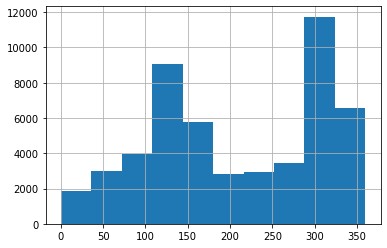

In [25]:
df['courseDegree'].hist()

<AxesSubplot:>

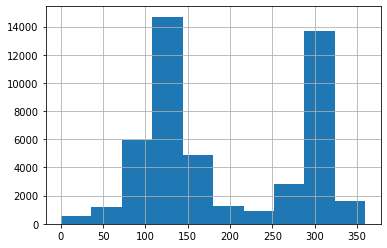

In [26]:
df['calc_deg'].hist()

<AxesSubplot:>

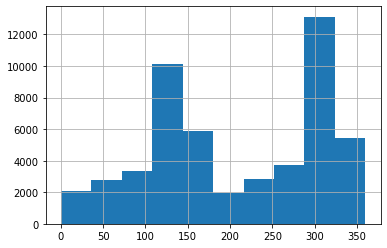

In [27]:
df['deg'].hist()

In [32]:
df['deg'].isna().sum(), df['calc_deg'].isna().sum()

(0, 3719)

<AxesSubplot:>

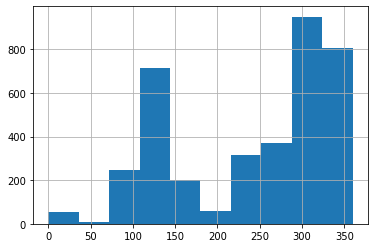

In [35]:
df.loc[df['calc_deg'].isna(), 'courseDegree']

In [29]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df['deg'], df['calc_deg'], squared=False)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').